In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas(ascii=True)

from rdkit import Chem
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering, DBSCAN, SpectralClustering
from scipy.stats import ks_2samp, chisquare,  power_divergence

import tmap, os
from faerun import Faerun
from mhfp.encoder import MHFPEncoder
from rdkit.Chem import AllChem

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from sklearn.decomposition import PCA
from molmap import dataset
import seaborn as sns


import matplotlib.pyplot as plt
%matplotlib inline

RDKit WARNING: [17:55:35] Enabling RDKit 2019.09.2 jupyter extensions


In [3]:
df_train = pd.read_csv('./train.csv', index_col = 0)
df_valid = pd.read_csv('./valid.csv',  index_col = 0)
df_test = pd.read_csv('./test.csv',  index_col = 0)
df_etc = pd.read_csv('./etc.del')
tasks = 'measured log solubility in mols per litre'
df_etc[tasks] = df_etc.Exp_LogS

In [4]:
df = df_train.append(df_valid).append(df_test).append(df_etc)
df = df.reset_index(drop=True)

train_idx = df.index[:len(df_train)]
valid_idx = df.index[len(df_train): len(df_train)+len(df_valid)]
test_idx = df.index[len(df_train)+len(df_valid): len(df_train)+len(df_valid) + len(df_test)]
etc_idx = df.index[-len(df_etc):]
len(train_idx), len(valid_idx), len(test_idx), len(etc_idx)

/home/shenwanxiang/.local/lib/python3.6/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


(901, 113, 113, 120)

In [5]:
dim = 1024
mols = [Chem.MolFromSmiles(s) for s in df.smiles]
ECFP4_fps = [AllChem.GetMorganFingerprintAsBitVect(x,2,dim) for x in tqdm(mols, ascii=True)]
ecfps = [tmap.VectorUchar(list(fp)) for fp in ECFP4_fps]
enc = tmap.Minhash(dim,seed = 42)

lf = tmap.LSHForest(dim)
lf.batch_add(enc.batch_from_binary_array(ecfps))
lf.index()

100%|##########| 1247/1247 [00:00<00:00, 58199.12it/s]


In [6]:
x, y, s, t, gp = tmap.layout_from_lsh_forest(lf)
X = np.array([x,y]).T


In [7]:
task_name = 'logS'
dft = pd.DataFrame(X, columns = ['TMAP1', 'TMAP2'])
dft[task_name] = df[tasks]
dft['Groups'] = np.nan
dft.loc[train_idx, 'Group']= 'train_data'
dft.loc[valid_idx, 'Group']= 'valid_data'
dft.loc[test_idx, 'Group']= 'test_data'
dft.loc[etc_idx, 'Group']= 'etc_data'
dft['smiles'] = df.smiles
branch_name = "Group"

order = ['train_data', 'valid_data', 'test_data', 'etc_data']


In [8]:
data_save_folder = './'

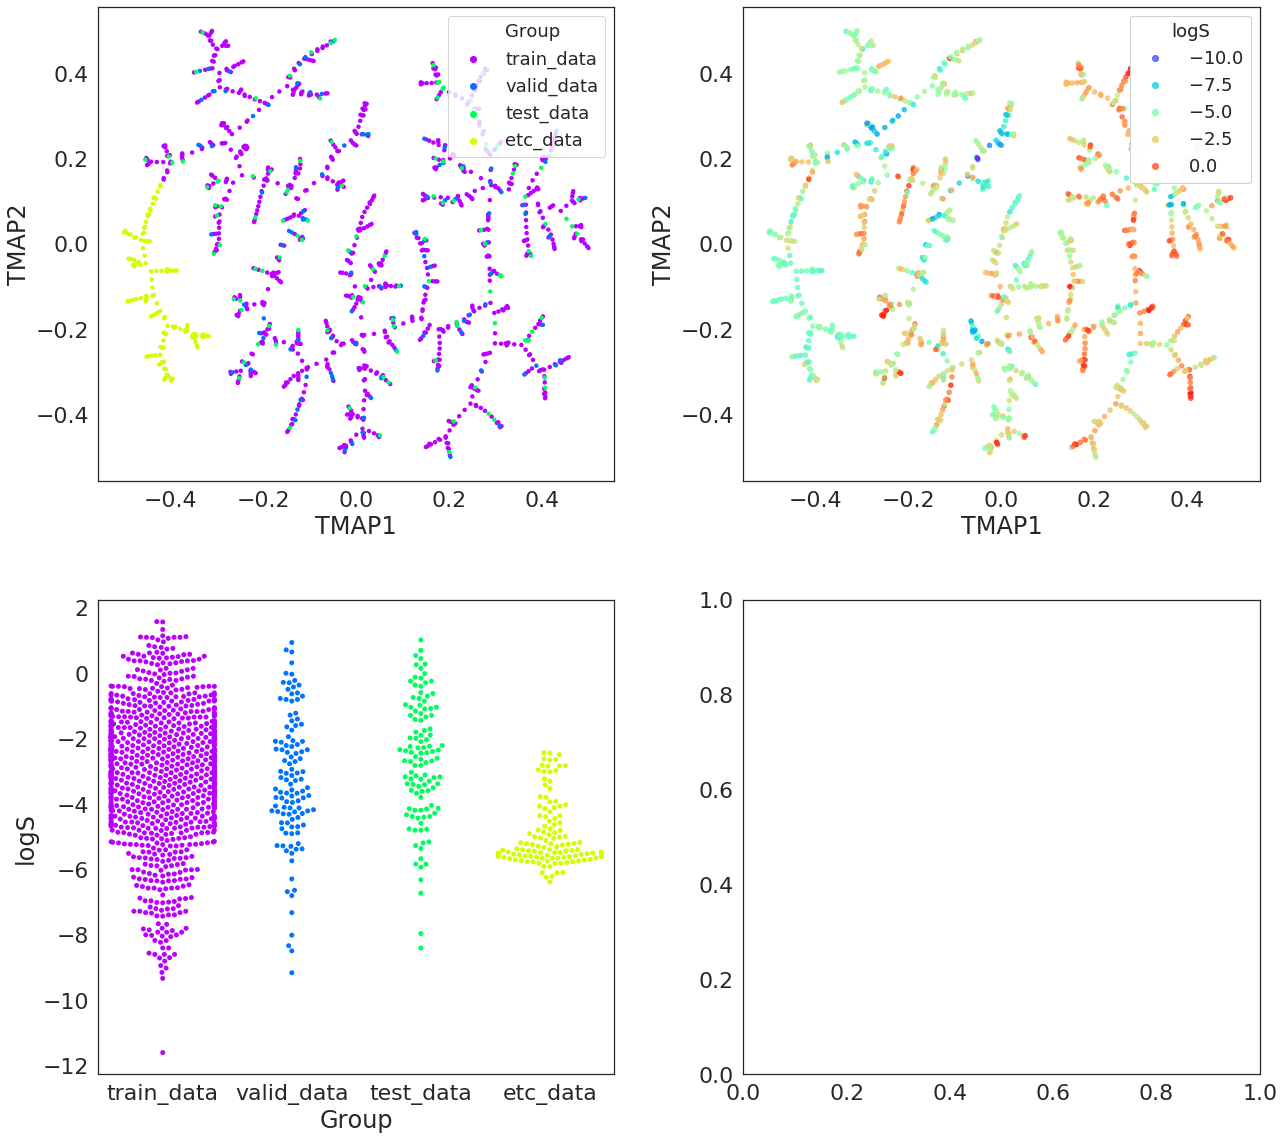

In [9]:
sns.set(style='white', font_scale = 2)
size = 20
#palette = sns.color_palette("Set1", n_clusters)


fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(18,16))
(ax1, ax3), (ax2, ax4) = axes


sns.set(style="white")

_ = sns.scatterplot('TMAP1', 'TMAP2',  hue = "Group", palette = "hsv_r",  hue_order = order, s = size,
                    data = dft, ax = ax1, linewidth = 0)
ax1.legend(loc='upper right')


num = 6
_ = sns.catplot(x = branch_name, y = task_name,  kind="swarm",  palette = "hsv_r", order = order, data=dft, ax= ax2 , )


    
im3 = ax3.scatter(x = dft.TMAP1, y = dft.TMAP2, alpha = .8, c = dft[task_name].tolist(), cmap = 'rainbow', s = size)
ax3.set_xlabel('TMAP1')
ax3.set_ylabel('TMAP2')

# fig.colorbar(im, ax=ax3)

lg3 = ax3.legend(*im3.legend_elements(num = num), loc="upper right", title=task_name, fontsize=18, )
ax3.add_artist(lg3)
lg3.set_title(task_name,prop={'size':18})

ax1.legend(fontsize=18, loc = 'upper right') 




fig.show()
plt.close(2)
fig.tight_layout()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.25)

fig.savefig(os.path.join(data_save_folder, 'chem_space.png'), dpi=300, format='png')
fig.savefig(os.path.join(data_save_folder, 'chem_space.pdf'), dpi=300, format='pdf')

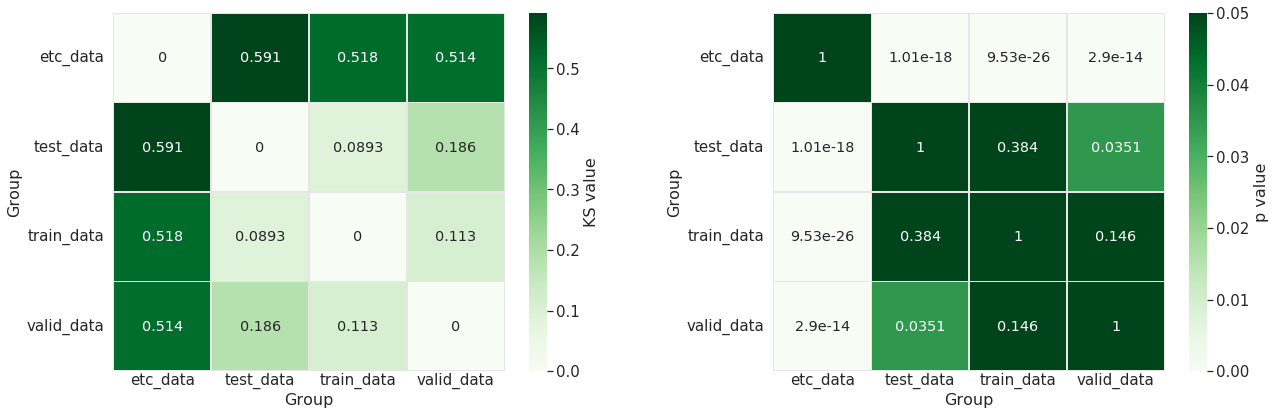

In [10]:
sns.set(style='white', font_scale = 1.2)
fig, axes = plt.subplots(ncols=2,figsize=(18,6))
ax1, ax2,  = axes

fontsize = 16


gb = dft.groupby('Group')[task_name].apply(lambda x:x.values)
ks_values = []
p_values = []
for i in gb.index:
    for j in gb.index:
        expected = gb.loc[i]
        observed = gb.loc[j]
        ks, p = ks_2samp(expected, observed)
        ks_values.append(ks)
        p_values.append(p)
arrv = np.array(ks_values).reshape(len(gb), len(gb)).astype('float16')
arrp = np.array(p_values).reshape(len(gb), len(gb))
dfv = pd.DataFrame(arrv, index = gb.index, columns = gb.index)
dfp = pd.DataFrame(arrp, index = gb.index, columns = gb.index)    

vax = sns.heatmap(dfv, annot=True, cmap = 'Greens', fmt='.3g',  ax = ax1,
                 linewidths  = 0.5, linecolor='0.9', cbar_kws={'label': 'KS value'})
vax.figure.axes[-1].yaxis.label.set_size(fontsize)
vax.collections[0].colorbar.ax.tick_params(labelsize=15) #cbar ticklabel size

pax = sns.heatmap(dfp, vmax = 0.05, annot=True, cmap = 'Greens', fmt='.3g',  ax= ax2,
                 linewidths  = 0.5, linecolor='0.9', cbar_kws={'label': 'p value', })

pax.figure.axes[-1].yaxis.label.set_size(fontsize)
pax.collections[0].colorbar.ax.tick_params(labelsize=15) #cbar ticklabel size


    
for ax in [ax1, ax2]:
    ax.set_yticklabels(dfv.index, rotation=0, fontsize="15", va="center")
    ax.set_xticklabels(dfv.index, rotation=0, fontsize="15", va="center")
    ax.axhline(y=0, color='0.9',lw= 0.5, ls =  '--')
    ax.axhline(y=dfv.shape[0], color='0.9',lw= 0.5, ls =  '--')
    ax.autoscale()
    ax.axvline(x=dfv.shape[1], color='0.9',lw= 0.5, ls =  '--')  
    ax.axvline(x=0, color='0.9',lw= 0.5, ls =  '--')
    ax.set_xlabel('Group', fontsize = 16)
    ax.set_ylabel('Group', fontsize = 16)

fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.35, hspace=None)

fig.savefig(os.path.join(data_save_folder, '%s_stat_test.png' % task_name), dpi=300, format='png')
fig.savefig(os.path.join(data_save_folder, '%s_stat_test.pdf' % task_name), dpi=300, format='pdf')
dfv['Value'] = 'statistic value'
dfv = dfv.reset_index().set_index(['Value', 'Group'])
dfp['Value'] = 'p value'
dfp = dfp.reset_index().set_index(['Value', 'Group'])
dfv.append(dfp).to_excel(os.path.join(data_save_folder, '%s_stat_test.xlsx' % task_name))